# Autoencoder

This model used two Con2D layers, 2 maxpooling layers, 1 flatten layer and 2 dense layers. The activation function is Relu.

In [1]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import MaxPooling1D, Conv1D, Dropout, Concatenate, Reshape, Conv2D, Dense, Flatten, Activation, MaxPooling2D, Input, UpSampling2D, Embedding, SpatialDropout1D
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from scipy import misc
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [2]:
(x_train,y_train), (x_test,y_test) = mnist.load_data()

In [3]:
#prepare the training and test data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(len(x_train), 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)

In [4]:
#construct encoder and decoder, and link encoder, encoder with model to build a complete autoencoder model
input_img = Input(shape=(28,28,1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
# "encoded" is the encoded representation of the input
encoded = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2),)(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = UpSampling2D((2,2))(x)
# "decoded" is the lossy reconstruction of the input
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)



# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0   

In [5]:
autoencoder.fit(x_train, x_train, batch_size=100, epochs=5, shuffle=True,validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 49s 812us/step - loss: 0.1904 - val_loss: 0.1374
Epoch 2/5
60000/60000 [==============================] - 48s 798us/step - loss: 0.1275 - val_loss: 0.1189
Epoch 3/5
60000/60000 [==============================] - 50s 826us/step - loss: 0.1161 - val_loss: 0.1120
Epoch 4/5
60000/60000 [==============================] - 49s 825us/step - loss: 0.1105 - val_loss: 0.1085
Epoch 5/5
60000/60000 [==============================] - 49s 818us/step - loss: 0.1070 - val_loss: 0.1044


In [6]:
decode_imgs = autoencoder.predict(x_test)

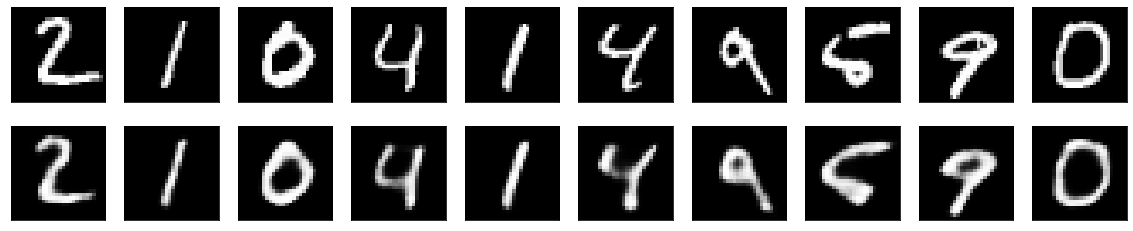

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decode_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Image Classification

## CNN

In this model, there are 11 layers in total, which is 2 Convolutional2D layer, 2 Maxpooling layer, 1 flatten layer and 2 dense layer.  
the first convolution2D layer has 25 kernels with size (5,5), the size of stride is 1.   
the next layer is the first maxpooling layer, it has kernel size of (2,2).  
the next layer is the second convolutional layer which has 50 kernels of size (5,5).  


In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
y_test = np_utils.to_categorical(y_test, 10)
y_train = np_utils.to_categorical(y_train, 10)

# design model
model = Sequential()
model.add(Conv2D(25, (5, 5), input_shape=(28, 28, 1)))
model.add(MaxPooling2D(2, 2))
model.add(Activation('relu'))
model.add(Conv2D(50, (5, 5)))
model.add(MaxPooling2D(2, 2))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
adam = Adam(lr=0.001)
# compile model
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
# training model
model_training = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=100, epochs=5)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 24, 24, 25)        650       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 25)        0         
_________________________________________________________________
activation_9 (Activation)    (None, 12, 12, 25)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 50)          31300     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 50)          0         
_________________________________________________________________
activation_10 (Activation)   (None, 4, 4, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)              

<Figure size 432x288 with 0 Axes>

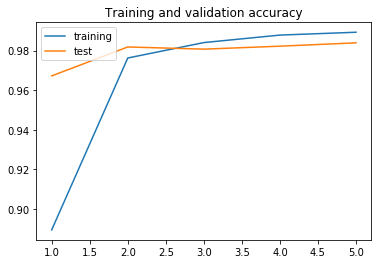

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(np.array(range(1,6)),np.array(model_training.history['accuracy']),label='training')
plt.plot(range(1,6),model_training.history['val_accuracy'],label='test')
plt.title('Training and validation accuracy')
plt.legend(loc = 'upper left')
plt.figure()

<Figure size 432x288 with 0 Axes>

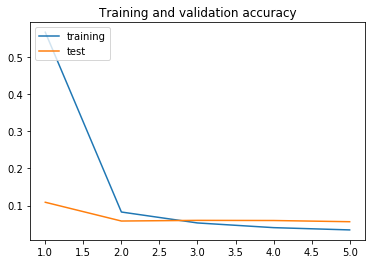

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(range(1,6),model_training.history["loss"],label='training')
plt.plot(range(1,6),model_training.history['val_loss'],label='test')
plt.title('Training and validation accuracy')
plt.legend(loc = 'upper left')
plt.figure()

In [21]:
# test model
print('the performance on test set is:')
print(model.evaluate(x_test, y_test, batch_size=100))
print('the performance on training set is:')
print(model.evaluate(x_train, y_train, batch_size=100))

the performance on test set is:
10000/10000 [==============================] - 1s 80us/step
[0.05635984194501362, 0.9839000105857849]
the performance on training set is:
60000/60000 [==============================] - 5s 76us/step
[0.03249768589817904, 0.9896166920661926]


## Transfer Learning 

In [50]:
# preparing the train dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_test = np_utils.to_categorical(y_test, 10)
y_train = np_utils.to_categorical(y_train, 10)
x_train.shape

(60000, 28, 28)

In [51]:
#reshape the image to 28*28*3
x_train = np.stack([x_train] * 3, axis = -1)
x_test = np.stack([x_test] * 3, axis = -1)
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])

In [52]:
# Normalise the data and change data type
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [53]:
x_train.shape,x_test.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

import the pre_trained model and discard the last layer, becasue the inbuilt last layer has 1000 neurons to get 1000 classification, in our dataset, we just need 10 classes, so we discard it in advance and add another dense layer which makes 10 classes. 

In [54]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16
#  Create base model of VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))

In [55]:
model1 = Sequential()
model1.add(conv_base)
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(96, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(10, activation="softmax"))

In [56]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
model1_training = model1.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=100, epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
18300/60000 [========>.....................] - ETA: 20:23 - loss: 2.3017 - accuracy: 0.1149

KeyboardInterrupt: 

In [ ]:
plt.plot(range(1,6),model1_training.history["acc"],label='training')
plt.plot(range(1,6),model1_training.history['val_acc'],label='test')
plt.title('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()


In [ ]:
plt.plot(range(1,11),model1_training.history["loss"],label='training')
plt.plot(range(1,11),model1_training.history['val_loss'],label='test')
plt.title('Training and validation loss')
plt.legend(loc = 'upper right')
plt.figure()

In [ ]:
# test model
print('the performance on test set is:')
print(model.evaluate(x_test, y_test, batch_size=100))
print('the performance on training set is:')
print(model.evaluate(x_train, y_train, batch_size=100))

# Text Classification

## RNN

In [75]:
import csv
result = []
with open("/Users/yoyozhang/Desktop/590Homework/assignment3/tweets_with_labels.csv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for i, line in enumerate(reader):
        result.append(line)
    
result = result[1:]

In [76]:
ids = [i[0] for i in result]
data_x = [i[1] for i in result]
data_y = [i[2:] for i in result]
print(len(data_x))
print(len(data_y))

77946
77946


In [77]:
result = []
for i, line in enumerate(data_y):
    try:
        tmp = np.array([float(j) for j in line])
    except ValueError:
        print("error on line",i)
    result.append(tmp)

data_y = np.array(result)

### tokenizer

In [78]:
data_x = [i.lower() for i in data_x]
#initiate the tokenizer
tk = Tokenizer(num_words = None, char_level = True, oov_token = 'UNK')
#Fit to the text
tk.fit_on_texts(data_x)

In [187]:
#clean text
import re
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;?!]')
TAG_BY_SPACE_RE = re.compile('#(\w+)')
DIGIT_BY_SPACE_RE = re.compile('\d+')

#make all the letters to lower case
x = [i.lower() for  i in data_x]

#discard all the special symbols
x = [REPLACE_BY_SPACE_RE.sub('',i) for i in x]
x = [BAD_SYMBOLS_RE.sub('',i) for i in x]
x = [TAG_BY_SPACE_RE.sub('',i) for i in x]
x = [DIGIT_BY_SPACE_RE.sub('',i) for i in x]


In [80]:
#Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each tw
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_x)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43805 unique tokens.


In [82]:
data_x = tokenizer.texts_to_sequences(data_x)
data_x = pad_sequences(data_x, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data_x.shape)
print('Shape of label tensor:', data_y.shape)

Shape of data tensor: (77946, 500)
Shape of label tensor: (77946, 15)


In [88]:
#train, test split
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

x = data_x[indices][:10000]
y = data_y[indices][:10000]

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9000, 500) (9000, 15)
(1000, 500) (1000, 15)


The first layer is the embedded layer that uses 100 length vectors to represent each word.  
SpatialDropout1D performs variational dropout in NLP models.  
The next layer is the LSTM layer with 100 memory units.  
The output layer must create 15 output values, one for each class.  
Activation function is softmax for multi-class classification.  
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [89]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=data_x.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(15, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test, y_test))

/Users/yoyozhang/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8100 samples, validate on 900 samples
Epoch 1/5
8100/8100 [==============================] - 63s 8ms/step - loss: 2.7611 - accuracy: 0.2753 - val_loss: 2.6835 - val_accuracy: 0.2833
Epoch 2/5
8100/8100 [==============================] - 62s 8ms/step - loss: 2.5262 - accuracy: 0.3583 - val_loss: 2.2516 - val_accuracy: 0.4622
Epoch 3/5
8100/8100 [==============================] - 61s 8ms/step - loss: 2.0999 - accuracy: 0.5410 - val_loss: 1.8702 - val_accuracy: 0.6811
Epoch 4/5
8100/8100 [==============================] - 63s 8ms/step - loss: 1.7998 - accuracy: 0.6701 - val_loss: 1.7087 - val_accuracy: 0.7233
Epoch 5/5
8100/8100 [==============================] - 62s 8ms/step - loss: 1.6622 - accuracy: 0.7156 - val_loss: 1.6236 - val_accuracy: 0.7522


In [ ]:
plt.plot(range(1,51),history.history["acc"],label='training')
plt.plot(range(1,51),history.history['val_acc'],label='test')
plt.title('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

In [ ]:
plt.plot(range(1,51),history.history["loss"],label='training')
plt.plot(range(1,51),history.history['val_loss'],label='test')
plt.title('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

In [90]:
print('the performance on test set is:')
print(model.evaluate(x_test, y_test, batch_size=100))
print('the performance on training set is:')
print(model.evaluate(x_train, y_train, batch_size=100))


1000/1000 [==============================] - 2s 2ms/step
The performance on CNN test set
  Loss: 1.650
  Accuracy: 0.745


## CNN

In [ ]:
max_features = 15
cnn = Sequential()
cnn.add(Embedding(max_features, 64))
cnn.add(Dropout(0.25))
cnn.add(Conv1D(64, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(15, activation='softmax'))
cnn.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

cnn_training = cnn.fit(x_train, y_train, epochs=50, batch_size=256, validation_data=(x_test, y_test))

### load data

In [91]:
import csv
result = []
with open("/Users/yoyozhang/Desktop/590Homework/assignment3/tweets_with_labels.csv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for i, line in enumerate(reader):
        result.append(line)
    
result = result[1:]
ids = [i[0] for i in result]
data_x = [i[1] for i in result]
data_y = [i[2:] for i in result]
print(len(data_x))
print(len(data_y))
result = []
for i, line in enumerate(data_y):
    try:
        tmp = np.array([float(j) for j in line])
    except ValueError:
        print("error on line",i)
    result.append(tmp)

data_y = np.array(result)

77946
77946


### tokenizer

In [92]:
data_x = [i.lower() for i in data_x]

In [93]:
#initiate the tokenizer
tk = Tokenizer(num_words = None, char_level = True, oov_token = 'UNK')
#Fit to the text
tk.fit_on_texts(data_x)

### Convert string to index

after getting all the right Vocabulary, we can transfer text into index representation

In [94]:
sequences = tk.texts_to_sequences(data_x)

Because the sentence have different lengths, we have to make all sentence as a same length, so the CNN could handle the batch data. We set the sentence length as 1014.

In [95]:
data = pad_sequences(sequences, maxlen=500, padding='post')

In [96]:
data = np.array(data, dtype = 'float32')
data.shape # All sentence length are 1014

(77946, 500)

### load embedding weights 

In [97]:
vocab_size = len(tk.word_index) # 70

embedding_weights = [] #(71, 70)
embedding_weights.append(np.zeros(vocab_size)) #(0, 70)

for char, i in tk.word_index.items(): # from index 1 to 69
    onehot = np.zeros(vocab_size)
    onehot[i-1] = 1
    embedding_weights.append(onehot)
embedding_weights = np.array(embedding_weights)
embedding_weights

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Model construction

In [98]:
# parameter 
input_size = 500
# vocab_size = 69
embedding_size = 69
conv_layers = [[256, 7, 3], 
               [256, 7, 3], 
               [256, 3, -1], 
               [256, 3, -1], 
               [256, 3, -1], 
               [256, 3, 3]]

fully_connected_layers = [1024, 1024]
num_of_classes = 15
dropout_p = 0.5
optimizer = 'adam'
loss = 'categorical_crossentropy'

In [99]:
# Embedding layer Initialization
#Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=data_x.shape[1])
embedding_layer = Embedding(vocab_size + 1, 
                            embedding_size,
                            input_length=input_size)

In [100]:
#Model 
# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')  # shape=(?, 500)
# Embedding 
x = embedding_layer(inputs)
# Conv 
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x) 
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x) # Final shape=(None, 34, 256)
        
x = Flatten()(x) # (None, 8704)
# Fully connected layers 
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x) # dense_size == 1024
    x = Dropout(dropout_p)(x)
# Output Layer
predictions = Dense(num_of_classes, activation='softmax')(x)
# Build model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) # Adam, categorical_crossentropy
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 500)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 500, 69)           4830      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 494, 256)          123904    
_________________________________________________________________
activation_18 (Activation)   (None, 494, 256)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 164, 256)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 158, 256)          459008    
_________________________________________________________________
activation_19 (Activation)   (None, 158, 256)          0   

### Training

In [101]:
#train, test split
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

x = data[indices][:10000]
y = data_y[indices][:10000]

X_train, X_test, Y_train, Y_test = train_test_split(x ,y , test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8000, 500) (8000, 15)
(2000, 500) (2000, 15)


In [102]:
# Training
model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          batch_size=128,
          epochs=10,
          verbose=2)

/Users/yoyozhang/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
 - 56s - loss: 598537.5989 - accuracy: 0.1608 - val_loss: 9244428.5760 - val_accuracy: 0.3040
Epoch 2/10
 - 55s - loss: 1576264603070.0801 - accuracy: 0.1374 - val_loss: 11243997477470.2070 - val_accuracy: 0.1020
Epoch 3/10
 - 56s - loss: 2456933615792029.5000 - accuracy: 0.1406 - val_loss: 7739699430110003.0000 - val_accuracy: 0.1235
Epoch 4/10
 - 56s - loss: 238203966890413408.0000 - accuracy: 0.1443 - val_loss: 453851259875790656.0000 - val_accuracy: 0.3040
Epoch 5/10
 - 56s - loss: nan - accuracy: 0.1271 - val_loss: nan - val_accuracy: 0.0150
Epoch 6/10
 - 55s - loss: nan - accuracy: 0.0160 - val_loss: nan - val_accuracy: 0.0150
Epoch 7/10
 - 52s - loss: nan - accuracy: 0.0160 - val_loss: nan - val_accuracy: 0.0150
Epoch 8/10
 - 53s - loss: nan - accuracy: 0.0160 - val_loss: nan - val_accuracy: 0.0150
Epoch 9/10
 - 54s - loss: nan - accuracy: 0.0160 - val_loss: nan - val_accuracy: 0.0150
Epoch 10/10
 - 52s - loss: nan - acc

In [103]:
accr = model.evaluate(X_test,Y_test)
print('The performance on CNN test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2000/2000 [==============================] - 4s 2ms/step
The performance on CNN test set
  Loss: nan
  Accuracy: 0.015
